In [1]:
import os
import scenic
# scenic_script = "./examples/carla/car.scenic"
scenic_script = "./examples/carla/test10.scenic"
scenario = scenic.scenarioFromFile(scenic_script)

/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/core/errors.py:160: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn('unable to install sys.excepthook to format Scenic backtraces')
/Users/edwardkim/Desktop/Scenic_Query/Scenic/src/scenic/simulators/carla/model.scenic:56: UserWarning: the "carla" package is not installed; will not be able to run dynamic simulations
  warnings.warn('the "carla" package is not installed; '


label.position:  (1227.6169566036467 @ 1375.0926529921517)
label.heading:  1.0654127268590772
sampled position: 1227.6169566036467 1375.0926529921517
sampled heading : 1.0654127268590772


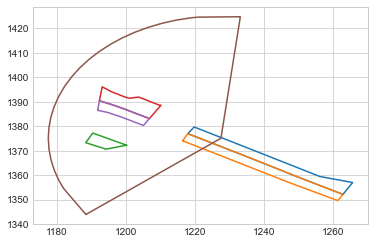

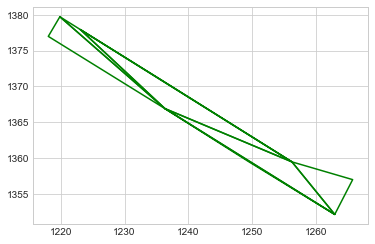

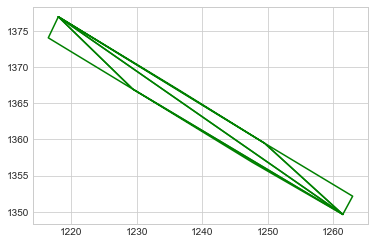

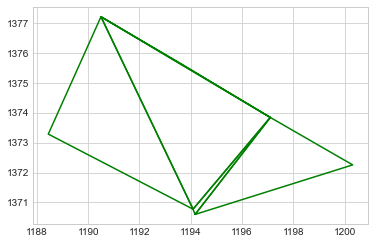

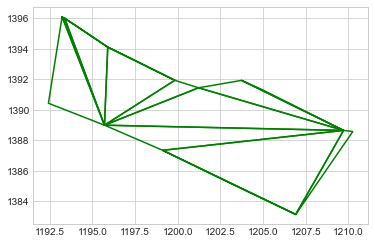

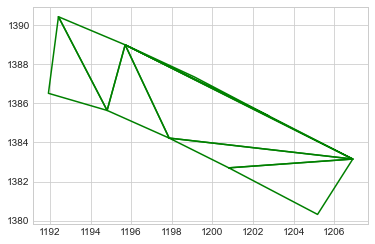

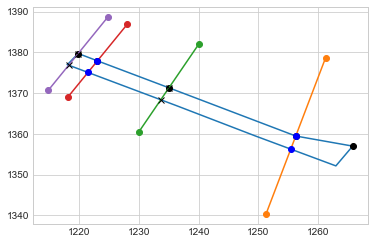

ValueError: min() arg is an empty sequence

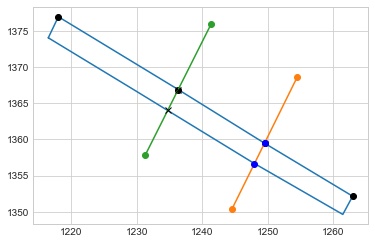

In [2]:

from scenic.core.distributions import *
from scenic.core.vectors import Vector
from scenic.core.regions import SectorRegion
import math
import subprocess
import os


# TODO : need to handle jointly dependent objs as well
def isPositionValid(obj, label, smt_file_path, ego_info, debug=False, falseTesting=False):
    
    # TODO : need to handle jointly dependent objs as well
    if os.path.isfile(smt_file_path):
        os.remove(smt_file_path)
    
    open(smt_file_path, 'w').close()
    writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

    # Instantiate cached_variables dictionary
    cached_variables = {}
    cached_variables['variables'] = []
    if not falseTesting:
        x = label.position.x
        y = label.position.y
        heading = ego_info['headingAngle']
    else:
        x = -54.57315926889603
        y = -15.476643362653856
        heading = -3.124554488402016
        
    # Create Ego's VisibleRegion
    print("sampled position: "+ str(x)+" "+ str(y))
    print("sampled heading : "+ str(heading))
    ego_labelled_position = Vector(x,y)
    ego_visibleDistance = ego_info['visibleDistance']
    ego_viewAngle = ego_info['viewAngle']
    ego_labelled_heading = heading
    egoVisibleRegion = SectorRegion(ego_labelled_position, ego_visibleDistance, \
                                    ego_labelled_heading, ego_viewAngle)
    cached_variables['egoVisibleRegion'] = egoVisibleRegion
    
    # instantiate smt_var
    x_var = findVariableName(smt_file_path, cached_variables, 'x', debug=debug)
    y_var = findVariableName(smt_file_path, cached_variables, 'y', debug=debug)
    smt_var = (x_var, y_var)
    writeSMTtoFile(smt_file_path, smt_assert("equal", x_var, str(x)))
    writeSMTtoFile(smt_file_path, smt_assert("equal", y_var, str(y)))
        
    # Encode object's position to SMT formula
    obj.position.encodeToSMT(smt_file_path, cached_variables, smt_var, debug = debug)

    writeSMTtoFile(smt_file_path, "(check-sat)")
    writeSMTtoFile(smt_file_path, "(exit)")

    if not debug:
        if subprocess.call("./run_smt_encoding.sh") == 1:
            return True
        else:
            return False
    else:
        print("DEBUG MODE: NO OUTPUT WILL BE RETURNED")
            
    return None


def testPositionSMTEncoding(scenario, obj, testNum=10, debug=False, falseTest=False):
    ego_visibleDistance = 50 #meters
    ego_viewAngle = 135 #deg
    smt_file_path = './test_smt_encoding.smt2'
    
    for i in range(testNum):
        resetConditionedObj(scenario)
        label = obj.sample()
        print("label.position: ", label.position)
        print("label.heading: ", label.heading)
        
        ego_info = {
            'visibleDistance' : ego_visibleDistance,
            'viewAngle' : math.radians(ego_viewAngle), #radians,
            'headingAngle' : label.heading #radians
        }
        
        valid = isPositionValid(obj, label, smt_file_path, ego_info, debug=debug, falseTesting=falseTest)
        print(valid)
        if not valid and not debug:
            return False
    return True

valid = testPositionSMTEncoding(scenario, scenario.egoObject, 10, debug=True, falseTest=False)
print("final: ", valid)

In [ ]:
from scenic.core.vectors import OrientedVector, Vector
import matplotlib.pyplot as plt
from scenic.core.type_support import toVector
from scenic.core.regions import PolygonalRegion, PointInRegionDistribution
import os.path as path
from scenic.core.regions import SectorRegion
from scenic.core.geometry import triangulatePolygon
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

laneSec = scenario.egoObject.position.operands[0].dist.object.object._conditioned.options[1]
# plt.plot(*laneSec.polygon.exterior.xy)
# for p in laneSec.centerline.points:
#     plt.plot(*p, 'ko')
list(laneSec.centerline.lineString.coords)


In [ ]:
from scenic.core.vectors import Vector
from shapely.geometry.linestring import LineString
from scenic.core.distributions import *
from shapely.geometry import MultiPoint, Point
from scenic.core.geometry import normalizeAngle


# find line perpendicular to the centerline segment & pass through the centerline point
def encodeHeading(elems, smt_file_path, smt_var, heading_var, debug=False):
    smt_encoding = None
    for elem in elems:
        centerlinePts = elem.centerline.points
        
        if debug:
            plt.plot(*elem.polygon.exterior.xy)
            for pt in centerlinePts:
                [x1,y1] = pt
                plt.plot(x1,y1,'ko')

        for i in range(len(centerlinePts)-1):
            # find the previous two points
            if i==0:
                prevLeftPt = elem.leftEdge.points[0]
                prevRightPt = elem.rightEdge.points[0]
                prevCenterPt = centerlinePts[0]

            [x1,y1] = prevCenterPt
            [x2,y2] = centerlinePts[i+1]
            slope = float(y2-y1)/float(x2-x1)

            if abs(slope) > 20:
                perpendicular_slope = 0
                bias = y2

                # find two points on the perpendicular line
                left_x, right_x = x2 - 5, x2 + 5
                left_y, right_y = bias, bias

            elif abs(slope) < 0.2:
                left_x, right_x = x2, x2
                left_y, right_y = y2 - 5, y2 + 5

            else:
                perpendicular_slope = -1 / float(slope)
                bias = y2 - perpendicular_slope * x2
                left_x, right_x = x2 - 5, x2 + 5
                left_y = perpendicular_slope * left_x + bias
                right_y = perpendicular_slope * right_x + bias

            left_pt = (left_x, left_y)
            right_pt = (right_x, right_y)
            line = LineString([left_pt, right_pt])

            # find the intersecting left/right points with left & right edge of the elem
            if i+1 < len(centerlinePts)-1:
                intersect_leftPt = elem.leftEdge.lineString.intersection(line)
                intersect_rightPt = elem.rightEdge.lineString.intersection(line)

                if isinstance(intersect_leftPt, MultiPoint):
                    intersect_leftPt = findClosestPoint(intersect_leftPt, Point(x2, y2))
                if isinstance(intersect_rightPt, MultiPoint):
                    intersect_rightPt = findClosestPoint(intersect_rightPt, Point(x2, y2))

                leftPt = (intersect_leftPt.x, intersect_leftPt.y)
                rightPt = (intersect_rightPt.x, intersect_rightPt.y)
            else:
                leftPt = elem.leftEdge.lineString.coords[-1]
                rightPt = elem.rightEdge.lineString.coords[-1]

            # encode a region left of the vector [leftEdgePt, rightEdgePt]
            leftOf_smt = encodeLeftRightOf(prevLeftPt, prevRightPt, smt_var, smt_file_path, side='left')

            # encode a region right of the vector [leftPt, leftPt]
            rightOf_smt = encodeLeftRightOf(leftPt, rightPt, smt_var, smt_file_path, side='right')

            # cache previous points
            prevLeftPt = leftPt
            prevRightPt = rightPt
            prevCenterPt = centerlinePts[i]

            # encode heading smt with ite
            joint_smt = smt_and(leftOf_smt, rightOf_smt)
            heading = normalizeAngle(Vector(x1,y1).angleTo(Vector(x2,y2)))

            if smt_encoding is None:
                smt_encoding = smt_ite(joint_smt, str(heading), '-1000')
            else:
                smt_encoding = smt_ite(joint_smt, str(heading), smt_encoding)

            if debug:
                print("i: ",i)
                print("heading: ", heading)
                print("prevCenterPt: ", prevCenterPt)
                print("nextCenterPt: ", centerlinePts[i+1])
                if i%2==0:
                    color1 = 'ro'
                    color2 = 'bo'
                else:
                    color1 = 'gx'
                    color2 = 'kx'
                plt.plot([left_x,right_x], [left_y,right_y], 'o-')
                plt.plot(intersect_leftPt.x, intersect_leftPt.y, color2)
                plt.plot(intersect_rightPt.x, intersect_rightPt.y, color2)
        if debug:
            plt.show()
            
    writeSMTtoFile(smt_file_path, smt_assert("equal", heading_var , smt_encoding))

    return heading_var

def encodeLeftRightOf(leftPt, rightPt, smt_var, smt_file_path, side):
    """ D >= 0 : the point, (xp,yp), is on the left-hand side or the line 
        D = (x2-x1) * (yp-y1) - (xp-x1) * (y2-y1)
    """
    (xp, yp) = smt_var
    (x1,y1) = (str(leftPt[0]), str(leftPt[1]))
    (x2,y2) = (str(rightPt[0]), str(rightPt[1]))
    x2_x1 = smt_subtract(x2,x1)
    yp_y1 = smt_subtract(yp,y1)
    mult1 = smt_multiply(x2_x1, yp_y1)
    xp_x1 = smt_subtract(xp,x1)
    y2_y1 = smt_subtract(y2,y1)
    mult2 = smt_multiply(xp_x1, y2_y1)
    D = smt_subtract(mult1, mult2)
    if side == 'left':
        smt_encoding = smt_lessThanEq('0', D)
    else:
        smt_encoding = smt_lessThanEq(D ,'0')
        
#     writeSMTtoFile(smt_file_path, smt_encoding)
    return smt_encoding

def findClosestPoint(multipoint, point):
    multiPts = list(multipoint.geoms)
    dist = []
    for pt in multiPts:
        dist.append(pt.distance(point))
    return multiPts[dist.index(min(dist))]


smt_file_path = './test_smt_encoding.smt2'

if os.path.isfile(smt_file_path):
    os.remove(smt_file_path)

open(smt_file_path, 'w').close()
writeSMTtoFile(smt_file_path, '(set-logic QF_NRA)')

smt_var = ('x','y')
declare_var_x = "(declare-fun "+'x'+" () Real)"
declare_var_y = "(declare-fun "+'y'+" () Real)"
writeSMTtoFile(smt_file_path, "(declare-fun "+'heading'+" () Real)")
writeSMTtoFile(smt_file_path, declare_var_x)
writeSMTtoFile(smt_file_path, declare_var_y)

encodeHeading(lanes, smt_file_path, smt_var, 'heading', debug=True)
writeSMTtoFile(smt_file_path, smt_assert("equal", 'x', '50'))
writeSMTtoFile(smt_file_path, smt_assert("equal", 'y', '-88.5'))

writeSMTtoFile(smt_file_path, "(check-sat)")
writeSMTtoFile(smt_file_path, "(exit)")

In [ ]:
from shapely.geometry import Point
p = Point(0,1)
print(Point(*list(p.coords)[0]))